# Tasks for laboratory assignment 2

In [1]:
# imports section

import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from autocorrect import Speller
import nltk
from wordcloud import WordCloud

import gensim as gs
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec
import gensim.downloader as api

import matplotlib.pyplot as plt

import json
import re

# Download the necessary resources
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Extract data from the json file 

Write a script, that would extract all the the data from the json file and return it in a list of texts for further use in the next tasks

In [2]:
def extract_texts_from_file(file_path):
    """
    Extract the text data from the json file

    Args:
        file_path (str): Relative location of the json file in the project.

    Returns:
        list: The list of texts as strings.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)["texts"]
    
    return data 

texts = extract_texts_from_file('resources/data.json')
print(texts)

['Oppenheimer, directed by Christopher Nolan, delves into the life of J. Robert Oppenheimer, the theoretical physicist who led the development of the atomic bomb. The film explores his moral and emotional struggles.', "Oppenheimer captures the life of the 'father of the atomic bomb' and his internal conflict after the success of the Manhattan Project. The film's complex narrative reflects on the cost of scientific achievement.", 'In Oppenheimer, Cillian Murphy delivers a riveting performance as the conflicted physicist who grapples with the consequences of his groundbreaking work on the atomic bomb, under the weight of global politics and ethics.', 'Oppenheimer is a cinematic exploration of ambition, guilt, and responsibility. Through stunning visuals and a thought-provoking story, Nolan brings the life of the brilliant but haunted physicist to the big screen.', 'Ducks are versatile waterfowl, known for their adaptability in freshwater and coastal habitats. With webbed feet and waterpr

## Process the texts

Write a script, that would process these texts. Processing should include:

- Lowercasing
- Removing Punctuation
- Removing Special Characters and Numbers
- Stemming or Lemmatization
- Handling Abbreviations
- Spelling Correction

In [4]:
def process_text(text: str, speller, abb):
    # Lowercasing
    text = text.lower()
    
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    
    # Removing special characters and numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)

    # Spelling correction
    text = speller(text)
    
    # Tokenization
    words = word_tokenize(text.lower()) 
    
    # Handling abbreviations
    words = [abb.get(word, speller(word)) for word in words] 
    words = word_tokenize(text)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words


def process_texts(texts):
    """
    Process the texts

    Args:
        texts (list): list of str texts to be processed.

    Returns:
        list: The list of texts as strings processed by script.
    """
    speller = Speller()
    normalization_dict = {
        "u": "you",
        "ur": "your",
        "r": "are",
        "pls": "please",
        "pos": "please",
        "thx": "thanks"
    }
    result = []
    for text in texts:
        result.append(
            process_text(text, speller=speller, abb=normalization_dict)
        )
    return result 

texts_processed = process_texts(texts)
print(texts_processed)

[['oppenheimer', 'directed', 'by', 'christopher', 'nolan', 'elf', 'into', 'the', 'life', 'of', 'j', 'robert', 'oppenheimer', 'the', 'theoretical', 'physicist', 'who', 'led', 'the', 'development', 'of', 'the', 'atomic', 'bomb', 'the', 'film', 'explores', 'his', 'moral', 'and', 'emotional', 'struggle'], ['oppenheimer', 'capture', 'the', 'life', 'of', 'the', 'father', 'of', 'the', 'atomic', 'bomb', 'and', 'his', 'internal', 'conflict', 'after', 'the', 'success', 'of', 'the', 'manhattan', 'project', 'the', 'film', 'complex', 'narrative', 'reflects', 'on', 'the', 'cost', 'of', 'scientific', 'achievement'], ['in', 'oppenheimer', 'million', 'murphy', 'delivers', 'a', 'riveting', 'performance', 'a', 'the', 'conflicted', 'physicist', 'who', 'grape', 'with', 'the', 'consequence', 'of', 'his', 'groundbreaking', 'work', 'on', 'the', 'atomic', 'bomb', 'under', 'the', 'weight', 'of', 'global', 'politics', 'and', 'ethic'], ['oppenheimer', 'is', 'a', 'cinematic', 'exploration', 'of', 'ambition', 'guil

## Visualize as cloud of words

Visualize the texts as a cloud of words.

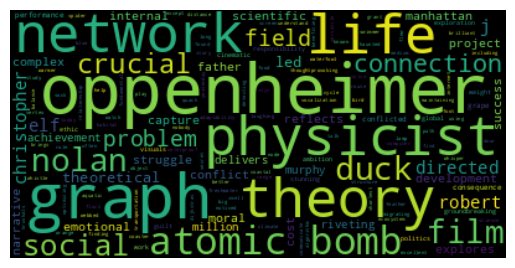

In [5]:
def visualize_texts(texts_processed):
    """
    Visualize the texts as cloud of words

    Args:
        texts_processed (list): list of texts, processed in previous task.

    Returns:
        None: None.
    """
    text_together = " ".join([word for sentence in texts_processed for word in sentence])
    
    wc = WordCloud().generate(text_together)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return None

visualize_texts(texts_processed)

## Calculate cosine similarities using TFIDF

Calculate the TFIDF score and cosine similarity between the texts. You may use gensim, write your own script using numpy or use other module. Output the result as a matrix $n\times n$ of cosine similarity scores (where $n$ is the length of texts list).

**Extra credit**: use word2vec word embeddings in vector spaces to get better TFIDF scores by representing each word as a vector.

In [6]:
def calcuate_tfidf(texts_processed):
    """
    Calculate TFIDF score between the texts in the list.

    Args:
        texts_processed (list): list of texts, processed in previous task.

    Returns:
        cosine_matrix (list): a matrix of cosine similarity scores.
    """  
    words = [word for sentence in texts_processed for word in sentence]
    
    vocab = sorted(set(words))
    vocab_dict = {k:i for i,k in enumerate(vocab)}
    
    x_tf = np.zeros((len(texts_processed), len(vocab)), dtype=int)
    for i, doc in enumerate(texts_processed):
        for word in doc:
            x_tf[i, vocab_dict[word]] += 1
    
    idf = np.log(x_tf.shape[0] / x_tf.astype(bool).sum(axis=0))
    
    x_tfidf = x_tf * idf
    
    x_tfidf_norm = x_tfidf / np.linalg.norm(x_tfidf, axis=1)[:,None]
    cosine_similarity = x_tfidf_norm @ x_tfidf_norm.T
    return cosine_similarity

cosine_matrix = calcuate_tfidf(texts_processed)
print(cosine_matrix)

[[1.00000000e+00 1.35856405e-01 1.18528744e-01 8.97270350e-02
  0.00000000e+00 9.38967663e-04 1.08387754e-02 5.23074849e-04
  5.49398674e-04 1.04693691e-02]
 [1.35856405e-01 1.00000000e+00 1.08270492e-01 5.02174070e-02
  0.00000000e+00 1.33724865e-03 2.17177540e-02 7.44946992e-04
  7.82436569e-04 2.09775711e-02]
 [1.18528744e-01 1.08270492e-01 1.00000000e+00 5.66764511e-02
  2.55095010e-02 8.72181875e-03 3.42074271e-02 2.82665151e-03
  1.48490291e-02 1.26213399e-02]
 [8.97270350e-02 5.02174070e-02 5.66764511e-02 1.00000000e+00
  1.32794501e-02 7.48543310e-02 2.97408150e-02 2.48687384e-02
  2.43298515e-02 1.03175998e-02]
 [0.00000000e+00 0.00000000e+00 2.55095010e-02 1.32794501e-02
  1.00000000e+00 2.26396983e-02 5.26416095e-02 2.10373670e-03
  3.09126094e-02 2.12601977e-03]
 [9.38967663e-04 1.33724865e-03 8.72181875e-03 7.48543310e-02
  2.26396983e-02 1.00000000e+00 2.56327438e-02 2.18720739e-02
  1.05552482e-02 2.21037460e-02]
 [1.08387754e-02 2.17177540e-02 3.42074271e-02 2.97408150e

## Visualize data

Visualize the `cosine_matrix` data using matplotlib. Choose your own method of plotting the scores in a way, that the similarity indeces between texts would be instantly visible. Plot data about texts as well (a couple of first words in the document).

*Hint: remember heat maps, aren't they nice for this task?*

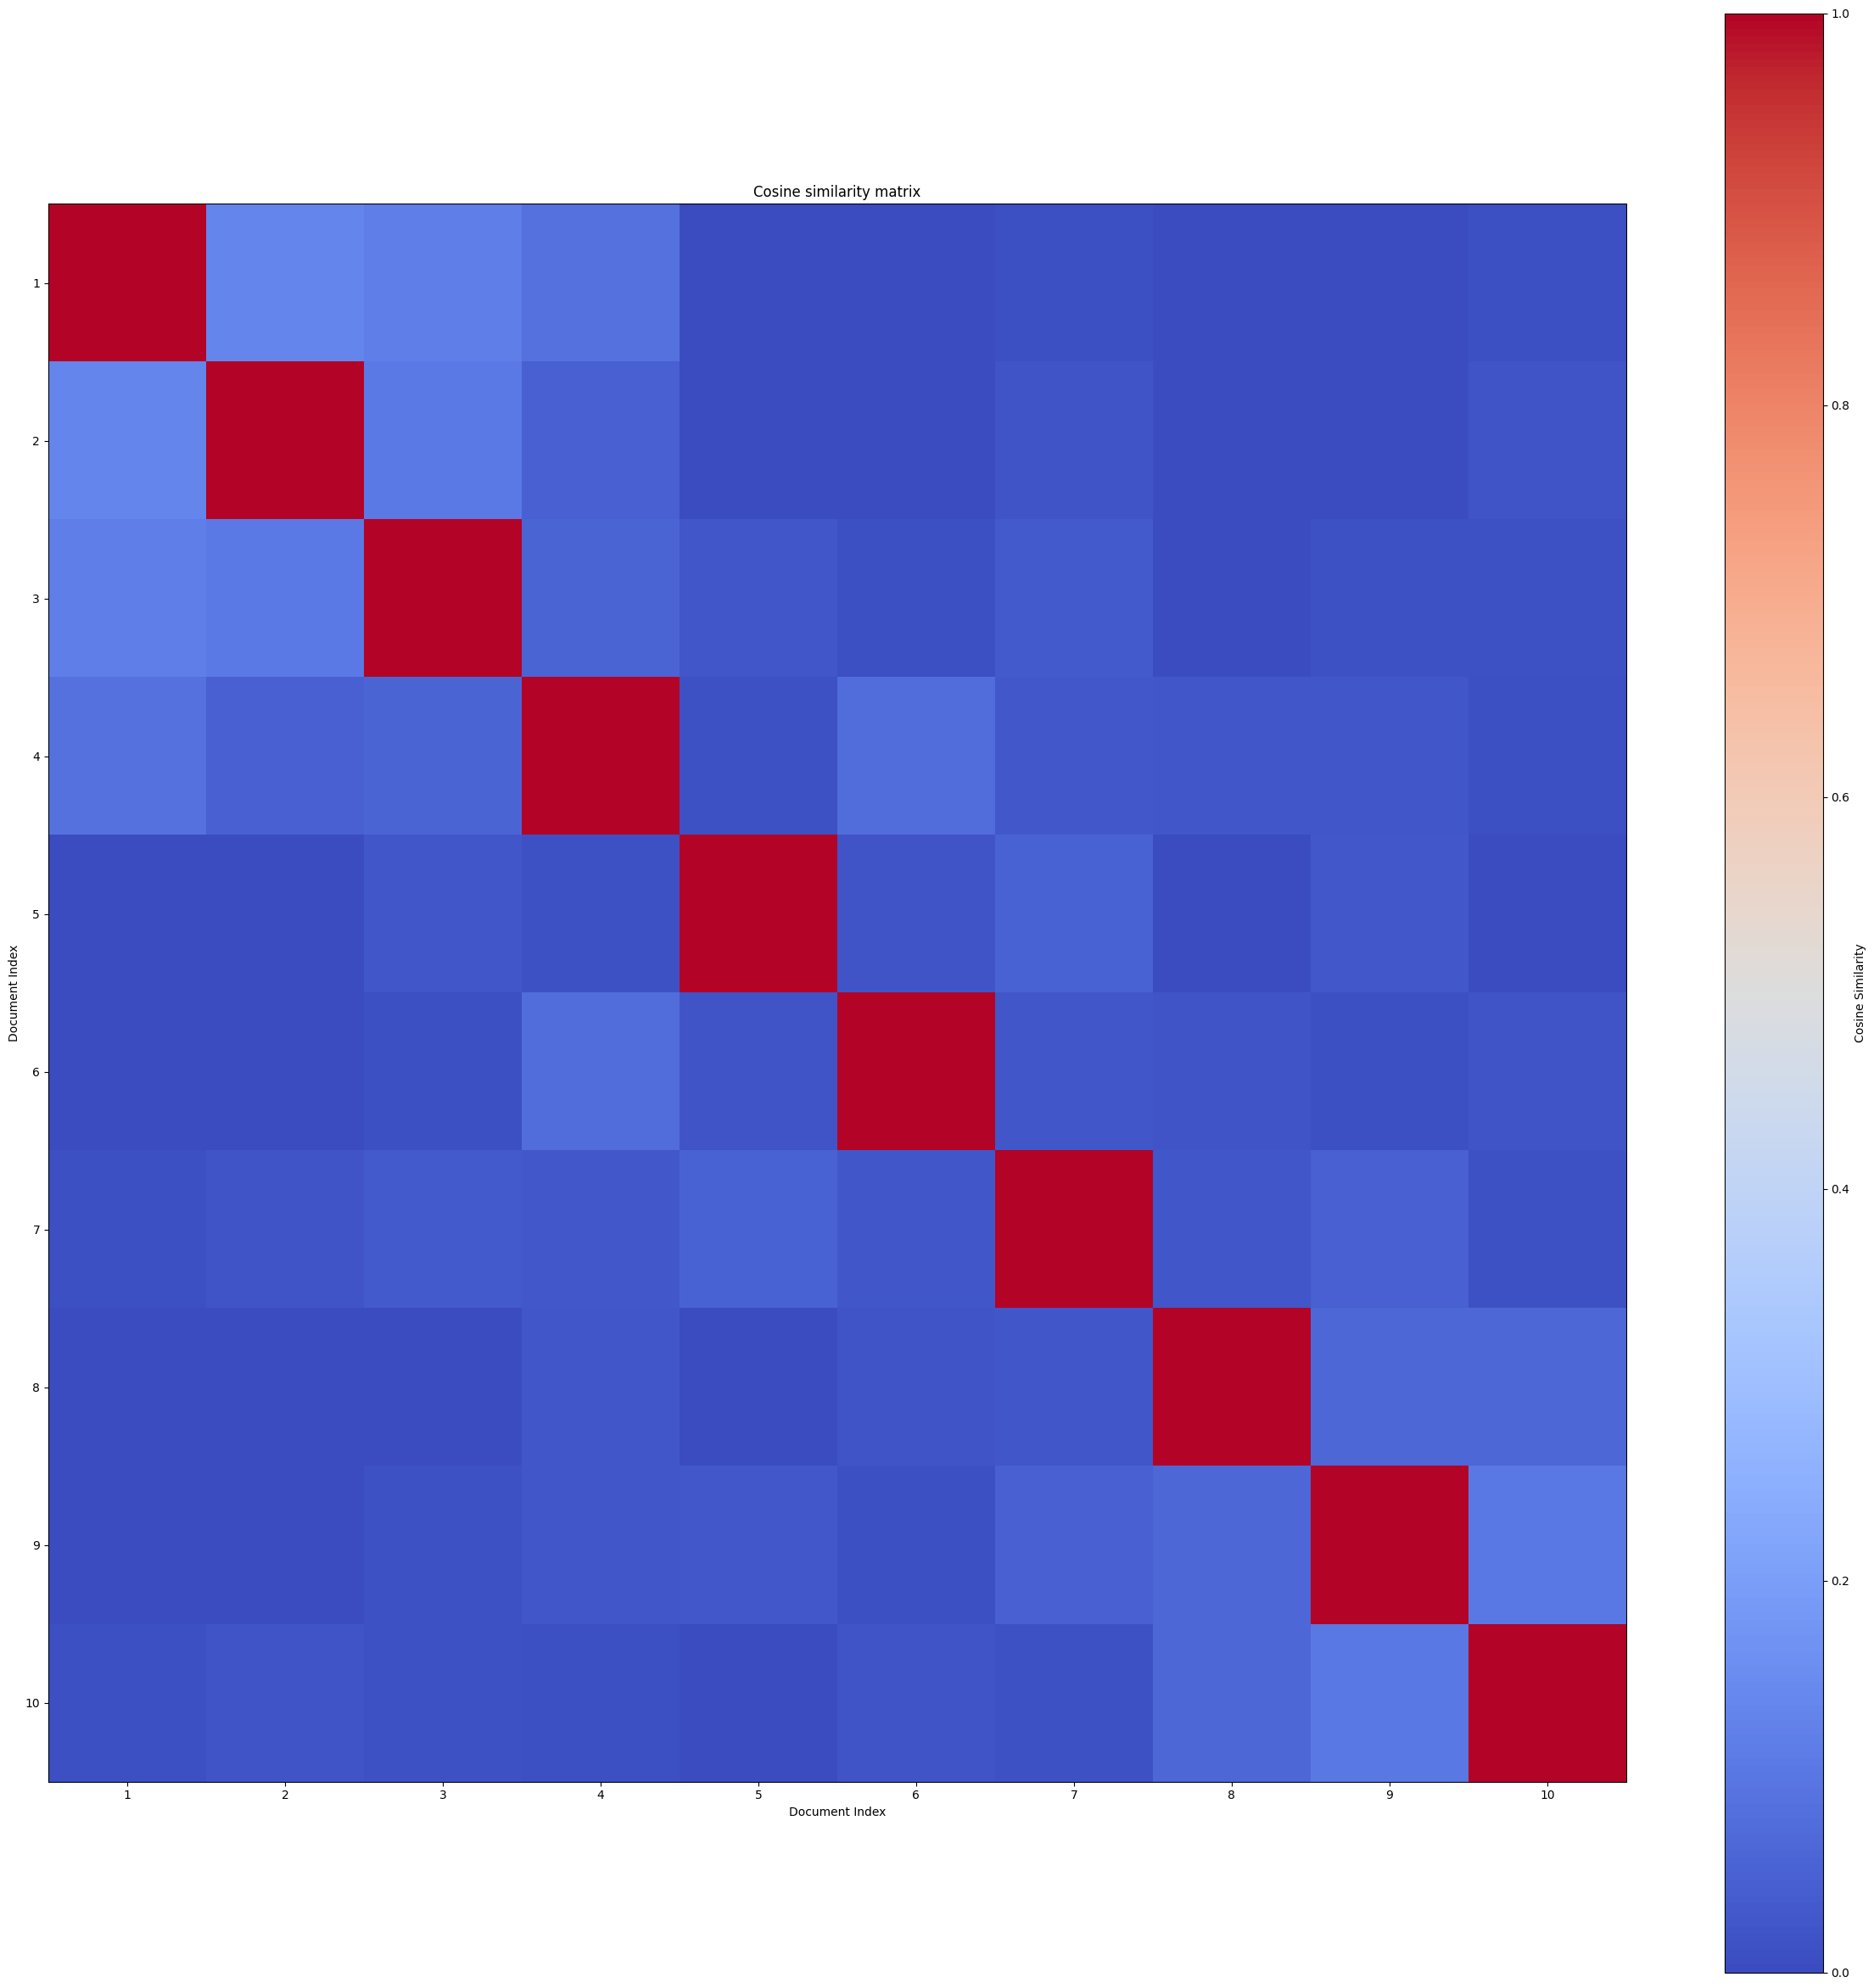

In [7]:
def visualize_data(cosine_matrix, texts_processed):
    """
    Visualize the cosine similarity matrix from the previous task. 

    Args:
        cosine_matrix (list): matrix of cosine similarity scores (values from 0.0 to 1.0 expected).
        texts_processed (list): list of texts, processed in previous task.

    Returns:
        None: None.
    """
    plt.figure(figsize=(30, 30))
    plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Cosine similarity matrix')
    plt.xlabel('Document Index')
    plt.ylabel('Document Index')
    plt.xticks(ticks=np.arange(cosine_matrix.shape[1]), labels=np.arange(1, cosine_matrix.shape[1] + 1))
    plt.yticks(ticks=np.arange(cosine_matrix.shape[0]), labels=np.arange(1, cosine_matrix.shape[0] + 1))
    return None

visualize_data(cosine_matrix, texts_processed)

## Analyse your own text using TFIDF (or any other method)

Analyse your own text using previous methods. You may use API fetching to get text data, download texts from Kaggle or use any texts you want. Find cosine similarities and visualize them.

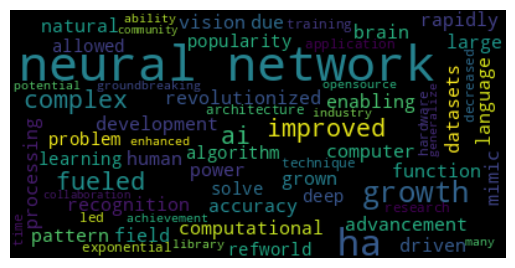

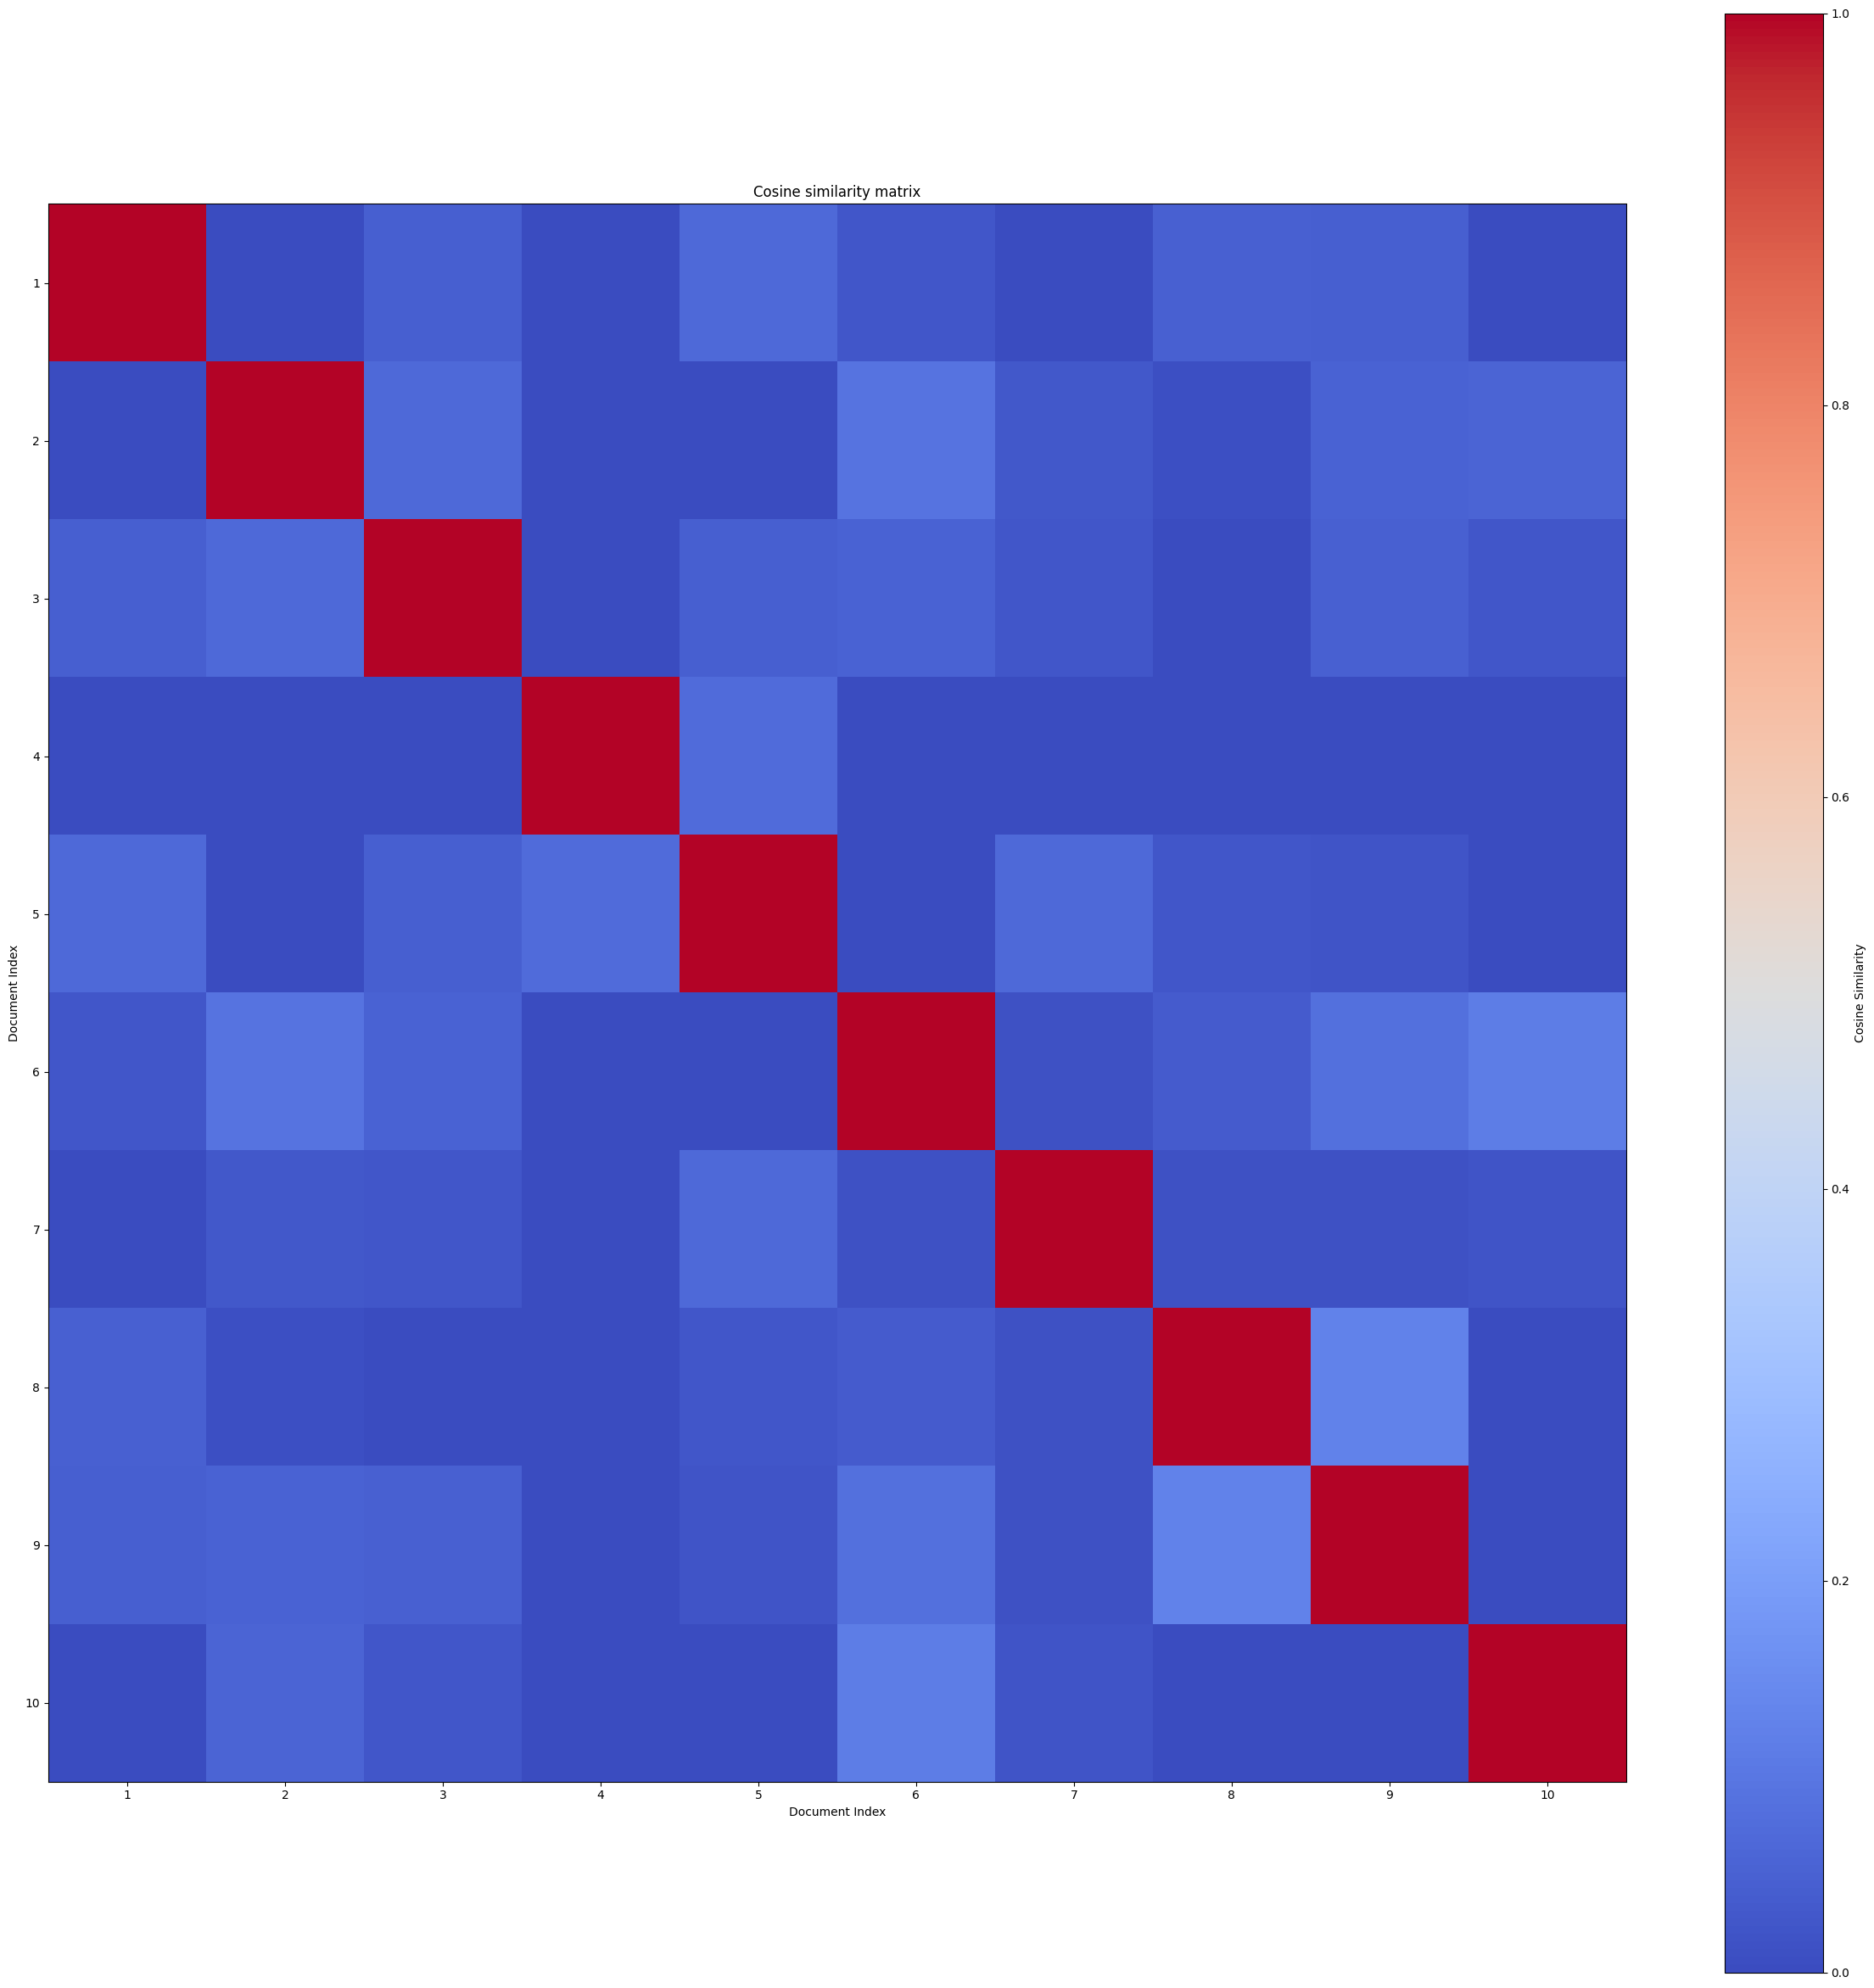

In [8]:
def get_texts():
    """
    Get the texts you want to analyse. Either API fetching, Kaggle or any other source.

    Args:
        None: None.

    Returns:
        list: list of texts.
    """
    with open("resources/my_data.txt", 'r') as file:
        list_of_texts = file.readlines()

    return list_of_texts

texts = get_texts()
texts_processed = process_texts(texts)
visualize_texts(texts_processed)
cosine_matrix = calcuate_tfidf(texts_processed)
visualize_data(cosine_matrix, texts_processed)